# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
import xgboost as xgb

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

from scipy import stats
from scipy.stats import skew
from time import time

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
#azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
#customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

In [3]:
# pickle dataframes to speed-up data loading next time
#azdias.to_pickle('azdias.pkl')
#customers.to_pickle('customers.pkl')

In [4]:
# read in from pickle files
azdias = pd.read_pickle('azdias.pkl')
customers = pd.read_pickle('customers.pkl')

## Data Exploration and Visualization

In [5]:
# Shape of the general population dataset
azdias.shape

(891221, 366)

In [6]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
# Shape of the customers dataset
customers.shape

(191652, 369)

In [8]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [9]:
# Column differences between the datasets
set(customers.columns) - set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

The customers dataset has three columns that the general population dataset does not have. These three columns relate to the purchasing of the customer.

In [10]:
# Describe the general population dataset
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [11]:
# Describe the customers dataset
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


**Missing Values**

Based on "DIAS Attributes - Values 2017.xlsx", for some attributes there is a given value which corresponds to an unknown value. Replacing those given values with NaN will provides a more accurate description of the data.

In [12]:
# Manually create set of attributes and their "unknown" values to turn into Nan values
unknown_values = {'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ALTER_HH': [0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FRAU': [-1, 9],
 'KBA05_GBZ': [-1, 0],
 'KBA05_HERST1': [-1, 9],
 'KBA05_HERST2': [-1, 9],
 'KBA05_HERST3': [-1, 9],
 'KBA05_HERST4': [-1, 9],
 'KBA05_HERST5': [-1, 9],
 'KBA05_HERSTTEMP': [-1, 9],
 'KBA05_KRSAQUOT': [-1, 9],
 'KBA05_KRSHERST1': [-1, 9],
 'KBA05_KRSHERST2': [-1, 9],
 'KBA05_KRSHERST3': [-1, 9],
 'KBA05_KRSKLEIN': [-1, 9],
 'KBA05_KRSOBER': [-1, 9],
 'KBA05_KRSVAN': [-1, 9],
 'KBA05_KRSZUL': [-1, 9],
 'KBA05_KW1': [-1, 9],
 'KBA05_KW2': [-1, 9],
 'KBA05_KW3': [-1, 9],
 'KBA05_MAXAH': [-1, 9],
 'KBA05_MAXBJ': [-1, 9],
 'KBA05_MAXHERST': [-1, 9],
 'KBA05_MAXSEG': [-1, 9],
 'KBA05_MAXVORB': [-1, 9],
 'KBA05_MOD1': [-1, 9],
 'KBA05_MOD2': [-1, 9],
 'KBA05_MOD3': [-1, 9],
 'KBA05_MOD4': [-1, 9],
 'KBA05_MOD8': [-1, 9],
 'KBA05_MODTEMP': [-1, 9],
 'KBA05_MOTOR': [-1, 9],
 'KBA05_MOTRAD': [-1, 9],
 'KBA05_SEG1': [-1, 9],
 'KBA05_SEG10': [-1, 9],
 'KBA05_SEG2': [-1, 9],
 'KBA05_SEG3': [-1, 9],
 'KBA05_SEG4': [-1, 9],
 'KBA05_SEG5': [-1, 9],
 'KBA05_SEG6': [-1, 9],
 'KBA05_SEG7': [-1, 9],
 'KBA05_SEG8': [-1, 9],
 'KBA05_SEG9': [-1, 9],
 'KBA05_VORB0': [-1, 9],
 'KBA05_VORB1': [-1, 9],
 'KBA05_VORB2': [-1, 9],
 'KBA05_ZUL1': [-1, 9],
 'KBA05_ZUL2': [-1, 9],
 'KBA05_ZUL3': [-1, 9],
 'KBA05_ZUL4': [-1, 9],
 'KBA13_ALTERHALTER_30': [-1],
 'KBA13_ALTERHALTER_45': [-1],
 'KBA13_ALTERHALTER_60': [-1],
 'KBA13_ALTERHALTER_61': [-1],
 'KBA13_AUDI': [-1],
 'KBA13_AUTOQUOTE': [-1],
 'KBA13_BJ_1999': [-1],
 'KBA13_BJ_2000': [-1],
 'KBA13_BJ_2004': [-1],
 'KBA13_BJ_2006': [-1],
 'KBA13_BJ_2008': [-1],
 'KBA13_BJ_2009': [-1],
 'KBA13_BMW': [-1],
 'KBA13_CCM_1000': [-1],
 'KBA13_CCM_1200': [-1],
 'KBA13_CCM_1400': [-1],
 'KBA13_CCM_0_1400': [-1],
 'KBA13_CCM_1500': [-1],
 'KBA13_CCM_1400_2500': [-1],
 'KBA13_CCM_1600': [-1],
 'KBA13_CCM_1800': [-1],
 'KBA13_CCM_2000': [-1],
 'KBA13_CCM_2500': [-1],
 'KBA13_CCM_2501': [-1],
 'KBA13_CCM_3000': [-1],
 'KBA13_CCM_3001': [-1],
 'KBA13_FAB_ASIEN': [-1],
 'KBA13_FAB_SONSTIGE': [-1],
 'KBA13_FIAT': [-1],
 'KBA13_FORD': [-1],
 'KBA13_HALTER_20': [-1],
 'KBA13_HALTER_25': [-1],
 'KBA13_HALTER_30': [-1],
 'KBA13_HALTER_35': [-1],
 'KBA13_HALTER_40': [-1],
 'KBA13_HALTER_45': [-1],
 'KBA13_HALTER_50': [-1],
 'KBA13_HALTER_55': [-1],
 'KBA13_HALTER_60': [-1],
 'KBA13_HALTER_65': [-1],
 'KBA13_HALTER_66': [-1],
 'KBA13_HERST_ASIEN': [-1],
 'KBA13_HERST_AUDI_VW': [-1],
 'KBA13_HERST_BMW_BENZ': [-1],
 'KBA13_HERST_EUROPA': [-1],
 'KBA13_HERST_FORD_OPEL': [-1],
 'KBA13_HERST_SONST': [-1],
 'KBA13_KMH_110': [-1],
 'KBA13_KMH_140': [-1],
 'KBA13_KMH_180': [-1],
 'KBA13_KMH_0_140': [-1],
 'KBA13_KMH_140_210': [-1],
 'KBA13_KMH_211': [-1],
 'KBA13_KMH_250': [-1],
 'KBA13_KMH_251': [-1],
 'KBA13_KRSAQUOT': [-1],
 'KBA13_KRSHERST_AUDI_VW': [-1],
 'KBA13_KRSHERST_BMW_BENZ': [-1],
 'KBA13_KRSHERST_FORD_OPEL': [-1],
 'KBA13_KRSSEG_KLEIN': [-1],
 'KBA13_KRSSEG_OBER': [-1],
 'KBA13_KRSSEG_VAN': [-1],
 'KBA13_KRSZUL_NEU': [-1],
 'KBA13_KW_30': [-1],
 'KBA13_KW_40': [-1],
 'KBA13_KW_50': [-1],
 'KBA13_KW_60': [-1],
 'KBA13_KW_0_60': [-1],
 'KBA13_KW_70': [-1],
 'KBA13_KW_61_120': [-1],
 'KBA13_KW_80': [-1],
 'KBA13_KW_90': [-1],
 'KBA13_KW_110': [-1],
 'KBA13_KW_120': [-1],
 'KBA13_KW_121': [-1],
 'KBA13_MAZDA': [-1],
 'KBA13_MERCEDES': [-1],
 'KBA13_MOTOR': [-1],
 'KBA13_NISSAN': [-1],
 'KBA13_OPEL': [-1],
 'KBA13_PEUGEOT': [-1],
 'KBA13_RENAULT': [-1],
 'KBA13_SEG_GELAENDEWAGEN': [-1],
 'KBA13_SEG_GROSSRAUMVANS': [-1],
 'KBA13_SEG_KLEINST': [-1],
 'KBA13_SEG_KLEINWAGEN': [-1],
 'KBA13_SEG_KOMPAKTKLASSE': [-1],
 'KBA13_SEG_MINIVANS': [-1],
 'KBA13_SEG_MINIWAGEN': [-1],
 'KBA13_SEG_MITTELKLASSE': [-1],
 'KBA13_SEG_OBEREMITTELKLASSE': [-1],
 'KBA13_SEG_OBERKLASSE': [-1],
 'KBA13_SEG_SONSTIGE': [-1],
 'KBA13_SEG_SPORTWAGEN': [-1],
 'KBA13_SEG_UTILITIES': [-1],
 'KBA13_SEG_VAN': [-1],
 'KBA13_SEG_WOHNMOBILE': [-1],
 'KBA13_SITZE_4': [-1],
 'KBA13_SITZE_5': [-1],
 'KBA13_SITZE_6': [-1],
 'KBA13_TOYOTA': [-1],
 'KBA13_VORB_0': [-1],
 'KBA13_VORB_1': [-1],
 'KBA13_VORB_1_2': [-1],
 'KBA13_VORB_2': [-1],
 'KBA13_VORB_3': [-1],
 'KBA13_VW': [-1],
 'KKK': [-1, 0],
 'NATIONALITAET_KZ': [-1, 0],
 'ORTSGR_KLS9': [-1],
 'OST_WEST_KZ': [-1],
 'PLZ8_ANTG1': [-1],
 'PLZ8_ANTG2': [-1],
 'PLZ8_ANTG3': [-1],
 'PLZ8_ANTG4': [-1],
 'PLZ8_GBZ': [-1],
 'PLZ8_HHZ': [-1],
 'PRAEGENDE_JUGENDJAHRE': [-1, 0],
 'REGIOTYP': [-1, 0],
 'RETOURTYP_BK_S': [0],
 'SEMIO_DOM': [-1, 9],
 'SEMIO_ERL': [-1, 9],
 'SEMIO_FAM': [-1, 9],
 'SEMIO_KAEM': [-1, 9],
 'SEMIO_KRIT': [-1, 9],
 'SEMIO_KULT': [-1, 9],
 'SEMIO_LUST': [-1, 9],
 'SEMIO_MAT': [-1, 9],
 'SEMIO_PFLICHT': [-1, 9],
 'SEMIO_RAT': [-1, 9],
 'SEMIO_REL': [-1, 9],
 'SEMIO_SOZ': [-1, 9],
 'SEMIO_TRADV': [-1, 9],
 'SEMIO_VERT': [-1, 9],
 'SHOPPER_TYP': [-1],
 'SOHO_FLAG': [-1],
 'TITEL_KZ': [-1, 0],
 'VERS_TYP': [-1],
 'WOHNDAUER_2008': [-1, 0],
 'WOHNLAGE': [-1],
 'WACHSTUMSGEBIET_NB': [-1, 0],
 'W_KEIT_KIND_HH': [-1, 0],
 'ZABEOTYP': [-1, 9]}

In [13]:
# Replace unknown values in dataset with NaN
for attribute in unknown_values:
    # Check if attribute is in dataframe
    if attribute in azdias.columns:       
        for key in unknown_values[attribute]:
            azdias[attribute].replace(key, np.NaN, inplace=True)

**Missing Data**

In [14]:
# Get number and percent of missing data
azdias_null = azdias.isnull().sum()
azdias_null_percent = azdias_null / len(azdias) * 100

Text(0, 0.5, 'Percent of missing values %')

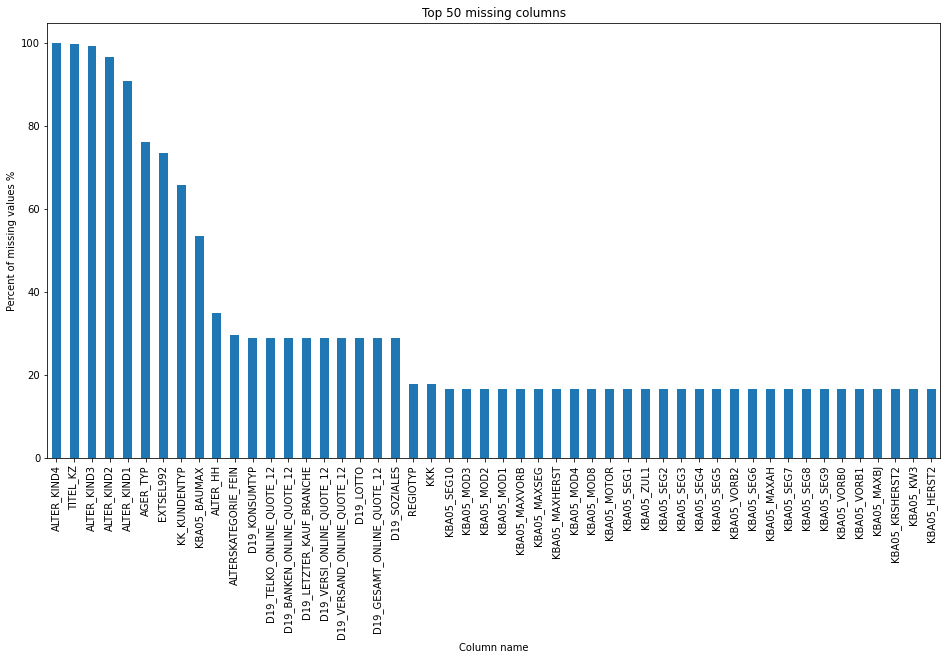

In [15]:
# Plot 50 columns with highest share of missing values
ax = azdias_null_percent.sort_values(ascending=False).head(50).plot(kind='bar', figsize=(16,8), title='Top 50 missing columns')
ax.set_xlabel("Column name")
ax.set_ylabel("Percent of missing values %")
#ax.figure.savefig('top_missing.png', dpi=500);

In [16]:
print("On average, columns have {}% of missing data.".format(round(azdias_null_percent.mean(),1)))

On average, columns have 11.4% of missing data.


In [17]:
print("97% of columns have {}% or less missing data.".format(round(azdias_null_percent.quantile(0.97),1)))

97% of columns have 28.9% or less missing data.


In [18]:
print("98% of columns have {}% or less missing data.".format(round(azdias_null_percent.quantile(0.98),1)))

98% of columns have 62.0% or less missing data.


There is a jump in the percentage of missing data in the column from 97% of the columns to 98% of the columns. This is a good point at which to drop columns. We could drop all columns that have more than 30% missing data. Looking at the graph of missing data percentages, though, it looks like we should drop columns with more than 40% missing data.

In [19]:
drop_null_cols = list(azdias_null_percent[azdias_null_percent>40].index)
print("{} columns that have more than 40% missing values will be dropped: {}".format(len(drop_null_cols),drop_null_cols))

9 columns that have more than 40% missing values will be dropped: ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


In [20]:
azdias_clean = azdias.drop(drop_null_cols, axis=1)

Let's also clean up the EINGEFUEGT_AM column so that it is in the proper date format

In [21]:
azdias_clean['EINGEFUEGT_AM'] = pd.to_datetime(azdias_clean['EINGEFUEGT_AM'], format='%Y-%m-%d ').dt.year

Let's also clean up the OST_WEST_KZ column by making the entries 'O' and 'W' numeric as 0 and 1.

In [22]:
azdias_clean['OST_WEST_KZ'].replace('O', 0, inplace=True)
azdias_clean['OST_WEST_KZ'].replace('W', 1, inplace=True)
azdias_clean['OST_WEST_KZ'] = pd.to_numeric(azdias_clean['OST_WEST_KZ'], errors = 'coerce')

**Rows with Missing Data**

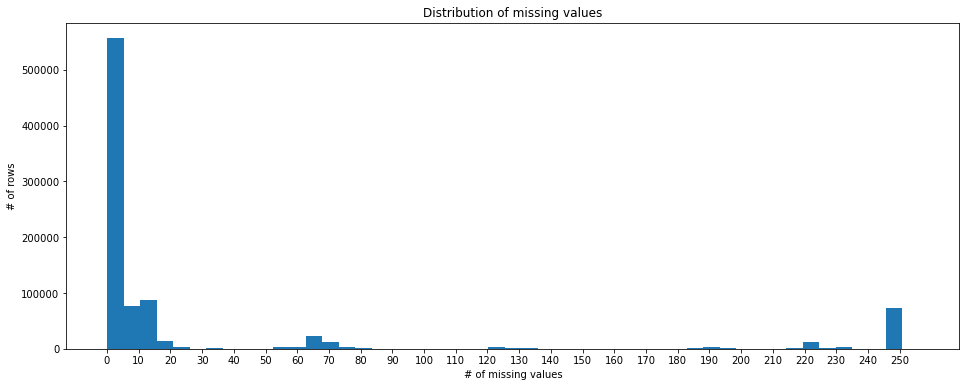

In [23]:
# Plot distribution of missing values
x = azdias_clean.isnull().sum(axis=1)
plt.figure(figsize=(16,6))
plt.hist(x, bins=np.linspace(min(x), max(x)+1))

plt.xticks(np.arange(min(x), max(x)+1, 10))
plt.ylabel('# of rows')
plt.xlabel('# of missing values')
plt.title('Distribution of missing values');

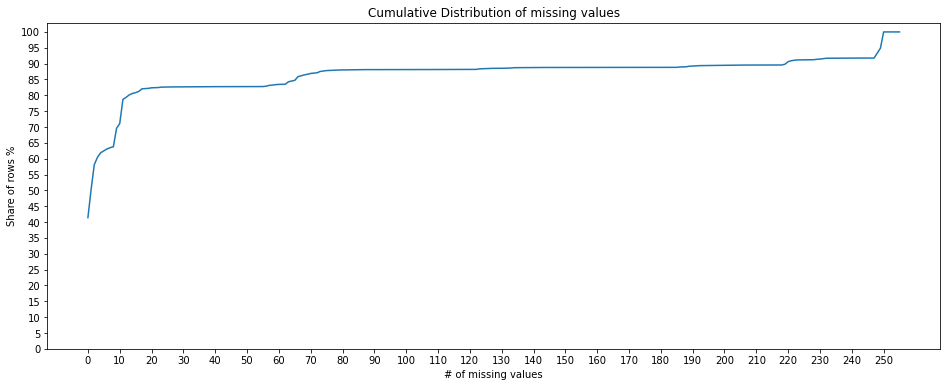

In [24]:
x = (azdias_clean.isnull().sum(axis=1).value_counts().sort_index().cumsum()/len(azdias_clean)) * 100
plt.figure(figsize=(16,6))
plt.plot(x)

plt.yticks(np.arange(0, 100+5, 5))
plt.xticks(np.arange(min(x.index), max(x.index)+1, 10))
plt.ylabel('Share of rows %')
plt.xlabel('# of missing values')
plt.title('Cumulative Distribution of missing values')
plt.savefig('dist_missing_rows.png', dpi=500);

In [25]:
# Percentage of rows that have less than the number of missing values

print("Percentage of \"good\" rows:",round(azdias_clean.isnull().sum(axis=1).value_counts().sort_index().cumsum()[:30]/azdias_clean.isnull().sum(axis=1).shape[0]*100,0))

Percentage of "good" rows: 0     41.0
1     50.0
2     58.0
3     60.0
4     62.0
5     62.0
6     63.0
7     63.0
8     64.0
9     70.0
10    71.0
11    79.0
12    79.0
13    80.0
14    81.0
15    81.0
16    81.0
17    82.0
18    82.0
19    82.0
20    82.0
21    82.0
22    82.0
23    83.0
24    83.0
25    83.0
26    83.0
27    83.0
28    83.0
29    83.0
dtype: float64


In [26]:
# Drop all rows with more than 11 values missing
azdias_clean = azdias_clean[azdias_clean.isnull().sum(axis=1) <= 11].reset_index(drop=True)
print('number of rows in new dataset: ',azdias_clean.shape[0])

number of rows in new dataset:  701432


Prep the customers dataset and clean in the same way

In [27]:
customers_clean = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)

In [28]:
customers_clean = customers_clean.drop(drop_null_cols, axis=1)
customers_clean['EINGEFUEGT_AM'] = pd.to_datetime(customers_clean['EINGEFUEGT_AM'], format='%Y-%m-%d ').dt.year
customers_clean['OST_WEST_KZ'].replace('O', 0, inplace=True)
customers_clean['OST_WEST_KZ'].replace('W', 1, inplace=True)
customers_clean['OST_WEST_KZ'] = pd.to_numeric(azdias_clean['OST_WEST_KZ'], errors = 'coerce')
customers_clean = customers_clean[customers_clean.isnull().sum(axis=1) <= 11].reset_index(drop=True)
print('number of rows in new dataset: ',customers_clean.shape[0])

number of rows in new dataset:  131987


In [29]:
azdias.shape

(891221, 366)

In [30]:
azdias_clean.shape

(701432, 357)

In [31]:
customers.shape

(191652, 369)

In [32]:
customers_clean.shape

(131987, 357)

In [33]:
# Reduce number of columns further by removing highly correlated columns
# see Chris Albon's website https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

# find correlation matrix    
corr_matrix = azdias_clean.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]

# drop columns from azdias_clean
azdias_clean = azdias_clean.drop(drop_columns, axis=1)

# repeat for customers

# find correlation matrix    
#corr_matrix = customers_clean.corr().abs()
#upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# identify columns to drop based on threshold limit
#drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]

# drop columns from customers_clean
customers_clean = customers_clean.drop(drop_columns, axis=1)

In [34]:
azdias_clean.shape

(701432, 250)

In [35]:
customers_clean.shape

(131987, 250)

### Impute, transform, and standardize features

**Classify attribute types and build pipelines**

Skewed continuous: Continuous numbers that are highly skewed should be log-transformed first before imputation. Missing values are then median imputed after transformation.

Binary: Missing values will be imputed based on the most common value.

Categorical: Categorical values will be one-hot encoded and then imputed based on the most common value.

Numerical: Missing values will be imputed based on the median value.

**Skewed Continuous**

In [36]:
# Get the continuous columns manually
continuous_cols = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW']

In [37]:
skewed_cols = []
for col in continuous_cols:
    if abs(skew(azdias_clean[col].dropna())) > 1:
        skewed_cols.append(col)


In [38]:
skewed_cols

['ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'KBA13_ANZAHL_PKW']

In [39]:
# Transform-impute Pipeline
skew_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),
    ('log_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('log_scale', StandardScaler())
])

**Binary**

In [40]:
num_cols = azdias_clean.select_dtypes(['float64', 'int64']).columns
binary_cols = []
for col in num_cols:
    n_unique = azdias_clean[col].dropna().nunique()
    if n_unique == 2:
        binary_cols.append(col)

In [41]:
binary_cols

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KBA05_SEG6',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP']

In [42]:
# Transform-impute Pipeline
binary_pipeline = Pipeline([
    ('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

**Categorical**

In [43]:
categorical_cols = list(azdias_clean.select_dtypes(['object']).columns)

In [44]:
categorical_cols

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE']

In [45]:
# Transform-impute Pipeline
categorical_pipeline = Pipeline([
    ('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

**Numerical**

In [46]:
numerical_cols = list(set(azdias_clean.columns) - set(skewed_cols) - set(binary_cols) - set(categorical_cols))

In [47]:
numerical_cols

['LNR',
 'AKT_DAT_KL',
 'D19_BANKEN_LOKAL',
 'KBA05_HERST1',
 'KBA05_SEG7',
 'FINANZ_MINIMALIST',
 'KBA05_SEG8',
 'D19_WEIN_FEINKOST',
 'KBA13_SEG_KLEINST',
 'D19_BANKEN_REST',
 'KBA05_HERST2',
 'SHOPPER_TYP',
 'KBA13_ALTERHALTER_45',
 'KBA13_KRSSEG_KLEIN',
 'D19_SOZIALES',
 'KBA13_SEG_UTILITIES',
 'D19_DROGERIEARTIKEL',
 'D19_VERSI_ONLINE_DATUM',
 'D19_BANKEN_GROSS',
 'KBA05_KRSZUL',
 'KBA13_VORB_1_2',
 'KBA05_HERSTTEMP',
 'FINANZ_HAUSBAUER',
 'KBA13_KMH_140_210',
 'KBA13_FAB_SONSTIGE',
 'KBA13_VORB_0',
 'SEMIO_MAT',
 'KBA13_SITZE_4',
 'D19_SAMMELARTIKEL',
 'KBA05_MODTEMP',
 'KBA13_ANTG1',
 'KBA13_BJ_1999',
 'ZABEOTYP',
 'KBA13_CCM_0_1400',
 'W_KEIT_KIND_HH',
 'D19_VERSICHERUNGEN',
 'KBA05_MAXVORB',
 'KBA05_HERST4',
 'SEMIO_FAM',
 'SEMIO_ERL',
 'KBA13_AUDI',
 'ALTER_HH',
 'VHN',
 'KBA13_SEG_MITTELKLASSE',
 'D19_GESAMT_OFFLINE_DATUM',
 'EINGEFUEGT_AM',
 'D19_BEKLEIDUNG_REST',
 'WOHNLAGE',
 'D19_FREIZEIT',
 'KBA13_SEG_SPORTWAGEN',
 'D19_TECHNIK',
 'KBA13_FORD',
 'KBA05_SEG3',
 'KBA13_SE

In [48]:
# Transform-impute Pipeline
numerical_pipeline = Pipeline([
    ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('num_scale', StandardScaler())
])

**Combine Pipelines**

In [49]:
transformers = [('skewed', skew_pipeline, skewed_cols),
               ('binary', binary_pipeline, binary_cols),
               ('categorical', categorical_pipeline, categorical_cols),
               ('numerical', numerical_pipeline, numerical_cols)]
column_transformer = ColumnTransformer(transformers = transformers)

**Transform Features**

In [50]:
azdias_trans = column_transformer.fit_transform(azdias_clean)

# Get column names from one hot encoded features
dummy_cols = list(column_transformer.transformers_[2][1].named_steps['onehot'].get_feature_names(categorical_cols))

# Create list of column names for transformed dataframe
column_names = skewed_cols + binary_cols + dummy_cols + numerical_cols

# Create transformed dataframe
azdias_trans = pd.DataFrame(azdias_trans, columns=[column_names])

In [51]:
# Check if all features are numerical
azdias_trans.dtypes.value_counts()

float64    358
dtype: int64

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

There are 358 features in the cleaned and transformed azdias dataset. Principal Component Analysis can be used to reduce the feature range.

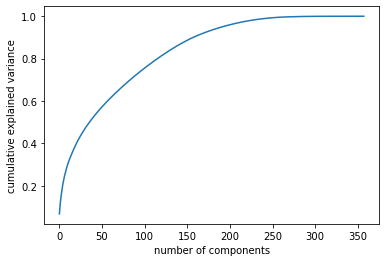

In [52]:
# Fit PCA object
pca = PCA().fit(azdias_trans)

# Plot scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [53]:
cum_variance = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_), columns=['cumulative_variance'])
cum_variance.set_index(cum_variance.index+1, inplace=True)

print('95% threshold of variance explained by {} components.'.format(cum_variance[cum_variance['cumulative_variance']>.95].index[0]))

95% threshold of variance explained by 192 components.


Of the more than 350 features in the dataset there are 192 that explain 95% of the variance. The dataset can be reduced by almost half of its feature range while only losing 5% of variance.

In [54]:
# Reduce the azdias dataset
pca = PCA(n_components=192).fit(azdias_trans)
azdias_reduced = pca.transform(azdias_trans)
azdias_reduced = pd.DataFrame(azdias_reduced)
print(pca.explained_variance_ratio_.sum())

0.9495658844623966


In [55]:
azdias_reduced.shape

(701432, 192)

### Clustering with Elbow Method

In [56]:
scores = []
for i in range(1, 31):
    km = KMeans(n_clusters=i, init='k-means++')
    km.fit(azdias_reduced.sample(20000))
    scores.append(km.inertia_)

Text(0, 0.5, 'Average Within-Cluster Distances')

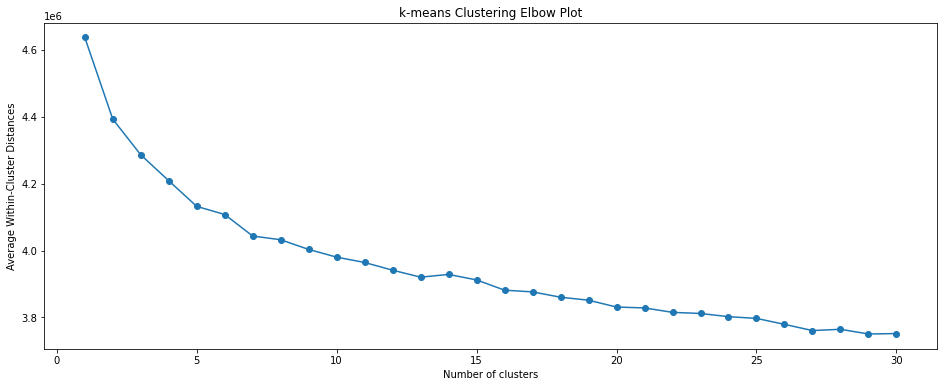

In [57]:
centers = np.linspace(1,30,30)
plt.figure(figsize=(16, 6))
plt.plot(centers, scores, '-o')
plt.title('k-means Clustering Elbow Plot')
plt.xlabel("Number of clusters")
plt.ylabel("Average Within-Cluster Distances")
#plt.xticks(list(range(1,31)))


There is no clear drop in average distance within clusters, but at about 12 clusters it is flat enough. So the line will be drawn there and 12 clusters will be used.

**Transform, reduce and cluster cleaned customers dataset**

In [58]:
# Create cluster pipeline
cluster_pipeline = Pipeline([
    ('transform', column_transformer),
    ('reduce', PCA(n_components = 192)),
    ('cluster', KMeans(n_clusters = 12, init = 'k-means++'))
])

In [59]:
# Fit cluster pipeline and create clustered general population dataframe
cluster_pipeline.fit(azdias_clean)
azdias_clustered = pd.DataFrame(cluster_pipeline.predict(azdias_clean), columns = ['Cluster'])

In [60]:
azdias_clean.shape

(701432, 250)

In [61]:
customers_clean.shape

(131987, 250)

In [62]:
# Create clustered customers dataframe
customers_clustered = pd.DataFrame(cluster_pipeline.predict(customers_clean), columns = ['Cluster'])

In [63]:
# Save custered datasets to pickle files
azdias_clustered.to_pickle('azdias_clustered')
customers_clustered.to_pickle('customers_clustered')

In [64]:
# Get cluster sizes in each dataset
population_clusters = azdias_clustered['Cluster'].value_counts().sort_index()
customer_clusters = customers_clustered['Cluster'].value_counts().sort_index()

In [65]:
# Concat the dataframes into a single one
clusters = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
clusters.columns = ['cluster','population','customers']

clusters['difference'] = (clusters['customers']/clusters['customers'].sum()*100) - (clusters['population']/clusters['population'].sum()*100)
clusters

,cluster,population,customers,difference
0,0,59342,3363,-5.912143
1,1,84547,1043,-11.263256
2,2,50648,14800,3.992568
3,3,65065,8145,-3.104962
4,4,67161,1081,-8.755821
5,5,36129,17511,8.116467
6,6,81528,48029,24.766110
7,7,72192,12390,-0.904800
8,8,54410,2728,-5.690118
9,9,45762,3696,-3.723806


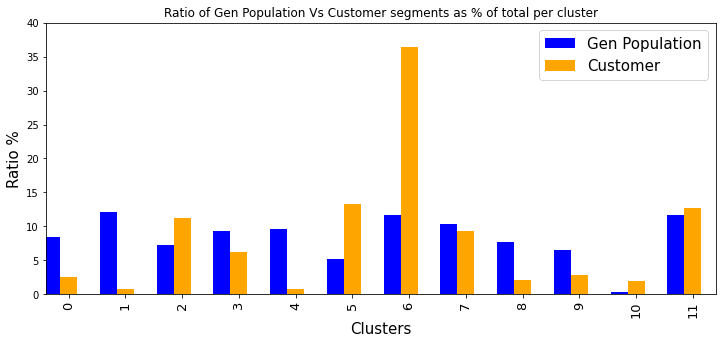

In [66]:
# Calculate the percentage of each cluster
clusters['population_percent'] = (clusters['population']/clusters['population'].sum()*100).round(2)
clusters['customers_percent'] = (clusters['customers']/clusters['customers'].sum()*100).round(2)

# Plot the clusters
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)
ax = clusters['population_percent'].plot(x=clusters['cluster'],width=-0.3,align='edge',color='blue',kind='bar',position=0)
ax = clusters['customers_percent'].plot(kind='bar',color='orange',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(12))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Gen Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()

Looking at how clusters are spread over the datasets, it looks like the biggest difference in the clusters is in cluster 0 and 6 positively towards the customers dataset and clusters 1 and 4 negatively towards the customers dataset.

In [67]:
# Postive and Negative weights
# Build ratios and weights
ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
ratio = ratio.round(3)
weights = pd.DataFrame(pca.components_, columns = azdias_trans.columns.values)
weights = weights.round(3)    
    
result = pd.concat([ratio, weights], axis = 1)

In [68]:
# Show highest positive and negative weights for cluster 0
print("Highest Positive weights:")
print(result.iloc[0].sort_values(ascending=False)[:5])
print('\n')
print("Negative weights:")
print(result.iloc[0].sort_values()[:5])

Highest Positive weights:
(KBA05_ANTG1,)       0.161
(KBA13_ANTG1,)       0.152
(KBA05_GBZ,)         0.150
(KBA05_AUTOQUOT,)    0.149
(MOBI_RASTER,)       0.147
Name: 0, dtype: float64


Negative weights:
(HH_EINKOMMEN_SCORE,)    -0.177
(ANZ_HAUSHALTE_AKTIV,)   -0.157
(ARBEIT,)                -0.131
(FINANZ_HAUSBAUER,)      -0.129
(KBA05_ANTG3,)           -0.110
Name: 0, dtype: float64


In [69]:
# Show highest positive and negative weights for cluster 6
print("Highest Positive weights:")
print(result.iloc[6].sort_values(ascending=False)[:5])
print('\n')
print("Negative weights:")
print(result.iloc[6].sort_values()[:5])

Highest Positive weights:
(KBA05_VORB0,)     0.175
(KBA05_MOTOR,)     0.158
(KBA05_MAXBJ,)     0.145
(KBA05_KW3,)       0.142
(KBA05_MAXSEG,)    0.137
Name: 6, dtype: float64


Negative weights:
(KBA05_KW1,)       -0.179
(KBA05_MAXVORB,)   -0.157
(KBA05_ZUL1,)      -0.143
(KBA05_VORB2,)     -0.139
(KBA05_CCM1,)      -0.128
Name: 6, dtype: float64


In [70]:
# Show highest positive and negative weights for cluster 1
print("Highest Positive weights:")
print(result.iloc[1].sort_values(ascending=False)[:5])
print('\n')
print("Negative weights:")
print(result.iloc[1].sort_values()[:5])

Highest Positive weights:
(KBA13_SEG_OBEREMITTELKLASSE,)    0.172
(KBA13_BMW,)                      0.168
(EWDICHTE,)                       0.157
(KBA13_SITZE_4,)                  0.154
(KBA13_SEG_SPORTWAGEN,)           0.150
Name: 1, dtype: float64


Negative weights:
(KBA13_KMH_140_210,)      -0.148
(KBA13_ALTERHALTER_60,)   -0.147
(KONSUMNAEHE,)            -0.142
(KBA13_HALTER_20,)        -0.140
(FIRMENDICHTE,)           -0.133
Name: 1, dtype: float64


In [71]:
# Show highest positive and negative weights for cluster 4
print("Highest Positive weights:")
print(result.iloc[4].sort_values(ascending=False)[:5])
print('\n')
print("Negative weights:")
print(result.iloc[4].sort_values()[:5])

Highest Positive weights:
(KBA13_KMH_210,)             0.219
(KBA13_CCM_1401_2500,)       0.193
(KBA13_CCM_2000,)            0.138
(KBA13_SEG_MITTELKLASSE,)    0.133
(FINANZ_ANLEGER,)            0.133
Name: 4, dtype: float64


Negative weights:
(KBA13_KW_0_60,)         -0.221
(KBA13_CCM_0_1400,)      -0.188
(KBA13_KMH_180,)         -0.173
(KBA13_SITZE_4,)         -0.165
(KBA13_SEG_MINIWAGEN,)   -0.164
Name: 4, dtype: float64


In [72]:
pca_components = cluster_pipeline.named_steps['reduce']
kmeans = cluster_pipeline.named_steps['cluster']
transformer =  cluster_pipeline.named_steps['transform']

cluster_centers = pca_components.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=column_names)

num_scale = transformer.named_transformers_['numerical'].named_steps['num_scale']
log_scale = transformer.named_transformers_['skewed'].named_steps['log_scale']
log_transform = transformer.named_transformers_['skewed'].named_steps['log_transform']

cluster_centers_df[numerical_cols] = num_scale.inverse_transform(cluster_centers_df[numerical_cols])
cluster_centers_df[skewed_cols] = log_scale.inverse_transform(cluster_centers_df[skewed_cols])
cluster_centers_df[skewed_cols] = log_transform.inverse_transform(cluster_centers_df[skewed_cols])

comparison_df = cluster_centers_df.T[[0, 6, 1, 4]]
comparison_df.columns=['interested_cluster_0','interested_cluster_6','not_interested_cluster_1','not_interested_cluster_4']

comparison_df[comparison_df.std(axis=1)>2]

,interested_cluster_0,interested_cluster_6,not_interested_cluster_1,not_interested_cluster_4
LNR,629966.341766,696795.670075,713907.954046,685127.393167
EINGEZOGENAM_HH_JAHR,2005.513717,1999.552777,2006.222911,2006.257802
GEBURTSJAHR,1126.482676,1125.642651,1100.853682,1276.381522


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [73]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)

In [74]:
mailout_train.shape

(42962, 367)

In [75]:
# Clean the dataset
#mailout_train_clean = mailout_train.drop(['RESPONSE'], axis=1)
mailout_train_clean = mailout_train.drop(drop_null_cols, axis=1)
mailout_train_clean['EINGEFUEGT_AM'] = pd.to_datetime(mailout_train_clean['EINGEFUEGT_AM'], format='%Y-%m-%d ').dt.year
mailout_train_clean['OST_WEST_KZ'].replace('O', 0, inplace=True)
mailout_train_clean['OST_WEST_KZ'].replace('W', 1, inplace=True)
mailout_train_clean['OST_WEST_KZ'] = pd.to_numeric(mailout_train_clean['OST_WEST_KZ'], errors = 'coerce')
mailout_train_clean = mailout_train_clean[mailout_train_clean.isnull().sum(axis=1) <= 11].reset_index(drop=True)
print('number of rows in new dataset: ', mailout_train_clean.shape[0])

number of rows in new dataset:  33582


In [76]:
mailout_train_clean.shape

(33582, 358)

In [77]:
X = mailout_train_clean.drop(['RESPONSE'], axis=1)
y = mailout_train_clean['RESPONSE']

In [78]:
# Set models for testing prediction
models = {'RandomForestClassifier': RandomForestClassifier(), 
          'AdaBoostClassifier': AdaBoostClassifier(), 
          'GradientBoostingClassifier': GradientBoostingClassifier()
         }

RandomForestClassifier
AUC train score = 1.0
AUC validation score = 0.57



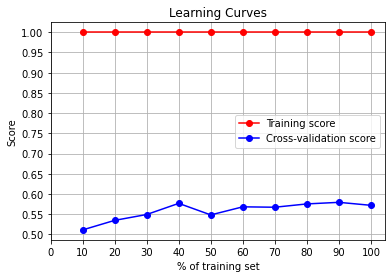

AdaBoostClassifier
AUC train score = 0.87
AUC validation score = 0.76



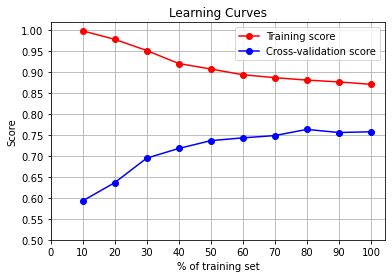

GradientBoostingClassifier
AUC train score = 0.96
AUC validation score = 0.76



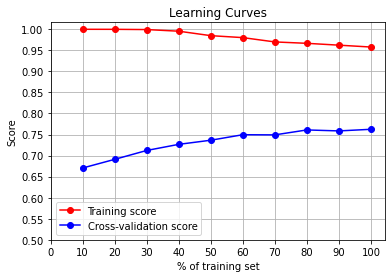

In [79]:
# Loop through models and generate learning curves
for model_key in models.keys():
    print(model_key)
    ml_pipeline = Pipeline([
        ('transform', column_transformer),
        ('model', models[model_key])
    ])
    mailout_train_clean_randomized = mailout_train_clean.sample(frac=1)
    y_rand = mailout_train_clean_randomized['RESPONSE']
    X_rand = mailout_train_clean_randomized.drop(['RESPONSE'],axis=1)
    
    train_sizes, train_scores, test_scores = learning_curve(
        ml_pipeline, X_rand, y_rand, scoring = 'roc_auc', train_sizes=np.linspace(.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print("AUC train score = {}".format(train_scores_mean[-1].round(2)))
    print("AUC validation score = {}".format(test_scores_mean[-1].round(2)))
    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("% of training set")
    plt.ylabel("Score")

    plt.plot(np.linspace(.1, 1.0, 10)*100, train_scores_mean, 'o-', color="red",
             label="Training score")
    plt.plot(np.linspace(.1, 1.0, 10)*100, test_scores_mean, 'o-', color="blue",
             label="Cross-validation score")

    plt.yticks(np.arange(0.50, 1.02, 0.05))
    plt.xticks(np.arange(0., 100.05, 10))
    plt.legend(loc="best")
    print("")
    plt.show()

The Random Forest Classifier shows high model bias with its consistently high train score. The model is overfitted to the training data and wouldn't be a good predictor for new data.

The AdaBoost Classifier shows better performance with a decrease of model bias as the sample size increases. However, after ~80% of the sample data, the curves stop converging.

The Gradient Boosting Classifier shows good performance and decreasing model bias. On top of that, the curves continue to converge all the way through the training set. It also has a high mean validation score. This is the classifier that will be used to continue to tune the model using grid-search.

In [81]:
#initialize with GradientBoostingClassifier
gbc_pipeline = Pipeline([
    ('transform', column_transformer),
    ('gbc', GradientBoostingClassifier(random_state=42))
])

parameters = {'gbc__learning_rate': [0.1, 0.2], 'gbc__n_estimators': [100],
             'gbc__max_depth': [3, 5], 'gbc__min_samples_split': [2,4]}        
        
gbc_gridsearch = GridSearchCV(gbc_pipeline, parameters, scoring = 'roc_auc')
#grid_obj = GridSearchCV(gbc_pipeline, parameters, scoring = 'roc_auc', verbose=50)

# Fit the grid search object to the training data and find the optimal parameters
gbc_grid_fit = gbc_gridsearch.fit(X, y)

In [82]:
# Get the estimator and predict
print(gbc_grid_fit.best_params_)
best_clf = gbc_grid_fit.best_estimator_
best_predictions = best_clf.predict_proba(X)[:, 1]

# Make predictions using unoptimized and the best model
predictions = (gbc_pipeline.fit(X, y)).predict_proba(X)[:, 1]

print("ROC score: {:.4f}".format(roc_auc_score(y, predictions)))
print("Final ROC score: {:.4f}".format(roc_auc_score(y, best_predictions)))

{'gbc__learning_rate': 0.1, 'gbc__max_depth': 5, 'gbc__min_samples_split': 4, 'gbc__n_estimators': 100}
ROC score: 0.9418
Final ROC score: 0.9991


Text(0.5, 0, 'feature importance')

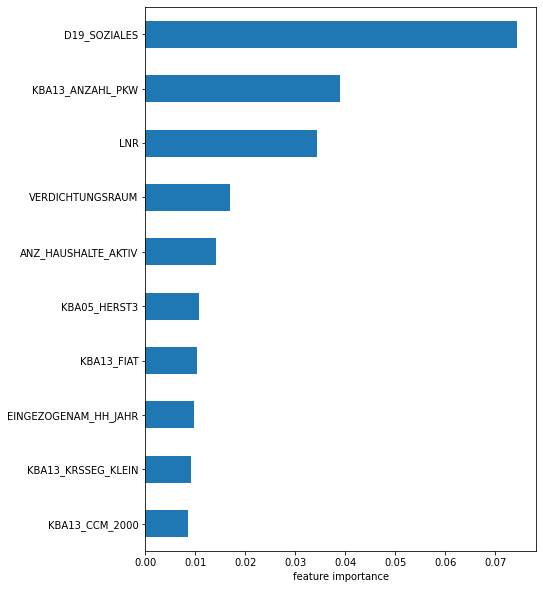

In [83]:
feature_importances = best_clf.named_steps['gbc'].feature_importances_
pd.Series(feature_importances, index=column_names).sort_values()[-10:].plot(kind='barh', figsize=(7,10))
plt.xlabel('feature importance')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [84]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)

In [85]:
mailout_test.shape

(42833, 366)

In [86]:
train_set= set(mailout_train.columns)
test_set= set(mailout_test.columns)

In [87]:
train_set - test_set

{'RESPONSE'}

In [88]:
# Clean the dataset
#mailout_train_clean = mailout_train.drop(['RESPONSE'], axis=1)
mailout_test_clean = mailout_test.drop(drop_null_cols, axis=1)
mailout_test_clean['EINGEFUEGT_AM'] = pd.to_datetime(mailout_test_clean['EINGEFUEGT_AM'], format='%Y-%m-%d ').dt.year
mailout_test_clean['OST_WEST_KZ'].replace('O', 0, inplace=True)
mailout_test_clean['OST_WEST_KZ'].replace('W', 1, inplace=True)
mailout_test_clean['OST_WEST_KZ'] = pd.to_numeric(mailout_train_clean['OST_WEST_KZ'], errors = 'coerce')
#mailout_test_clean = mailout_test_clean[mailout_test_clean.isnull().sum(axis=1) <= 11].reset_index(drop=True)
print('number of rows in new dataset: ', mailout_test_clean.shape[0])

number of rows in new dataset:  42833


In [89]:
mailout_test_clean.shape

(42833, 357)

In [90]:
#predict target values
kaggle_predict = best_clf.predict_proba(mailout_test_clean)[:,1]

In [91]:
kaggle = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=kaggle_predict)
kaggle.rename(columns={0: "RESPONSE"}, inplace=True)

In [92]:
kaggle.head(10)

,RESPONSE
LNR,
1754,0.021217
1770,0.018736
1465,0.000897
1470,0.000859
1478,0.000962
1782,0.219065
1485,0.001156
1519,0.021469
1835,0.006255


In [93]:
kaggle.to_csv('submission.csv')